# Machine Learning Modelle
1. [Entfernen von zukunftsbezogenen Features](#1)
1. [Multiple Lineare Regression](#2)
1. [Random Forest](#3)
1. [XGBoost](#4)
  1. [Permutation Importance](#5)
  1. [F-Score](#6)
  1. [SHAP Values](#7)
1. [Performance-Vergleich](#8)

In [55]:
!pip install darts

In [56]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from darts import TimeSeries
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [57]:
def add_lag_features(df, columns):
    """
    Fügt einem DataFrame Verzögerungs-Features (Lags) für die angegebenen Spalten hinzu. 
    Für jede Spalte in 'columns' wird ein Verzögerungs-Feature hinzugefügt.
    Jedes Verzögerungs-Feature ist eine Verschiebung der Originalspalte um eine Stunde.

    :param df: Pandas DataFrame, zu dem die Verzögerungs-Features hinzugefügt werden sollen.
    :param columns: Liste der Spaltennamen, für die Verzögerungs-Features erstellt werden sollen.
    :return: DataFrame mit den zusätzlichen Verzögerungs-Features.
    """
    lagged_df = df.copy()
    for column in columns:
        lagged_df[f'{column}_lag_1'] = lagged_df[column].shift(1)
    return lagged_df


def add_use_lags(df, lag_hours):
    """
    Fügt einem DataFrame Verzögerungs-Features (Lags) für die Spalten 'use' hinzu. 
    Für jeden Verzögerungswert in 'lag_hours' wird ein Verzögerungs-Feature hinzugefügt.
    Jedes Verzögerungs-Feature ist eine Verschiebung der Originalspalte um X Stunden.

    :param df: Pandas DataFrame, zu dem die Verzögerungs-Features hinzugefügt werden sollen.
    :param lag_hours: Liste der Verzögerungswerte, für die Verzögerungs-Features erstellt werden sollen.
    :return: DataFrame mit den zusätzlichen Verzögerungs-Features.
    """
    lagged_df = df.copy()
    for lag in lag_hours:
        lagged_df[f'use_lag_{lag}'] = lagged_df.use.shift(lag)
    return lagged_df


def print_metrics(actual, predicted):
    """
    Berechnet MAE, RMSE und MAPE zwischen den tatsächlichen und vorhergesagten Werten.
    :param actual: Array der tatsächlichen Werte
    :param predicted: Array der vorhergesagten Werte
    """
    actual, predicted = np.array(actual), np.array(predicted)

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f"MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}, MAPE: {round(mape, 2)} %")

In [58]:
df = pd.read_csv("../input/ps-ds3/ps_ds3.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)

df.head()

,use,outdoor_temp,app_outdoor_temp,humidity,is_holiday,hour,wday,day,month,is_off_day,...,dryg,furnace,kitchenapp,livingroom,microwave,oven,refrigerator,utilityroom,venthood,arima_preds
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.58575,-3.43,-7.00,0.86,True,0,0,1,1,True,...,NaN,NaN,NaN,NaN,NaN,0.008,NaN,NaN,NaN,1.440032
2018-01-01 01:00:00,0.43750,-3.75,-7.14,0.83,True,1,0,1,1,True,...,NaN,NaN,NaN,NaN,NaN,0.008,NaN,NaN,NaN,0.819209
2018-01-01 02:00:00,0.47875,-3.89,-7.26,0.79,True,2,0,1,1,True,...,NaN,NaN,NaN,NaN,NaN,0.008,NaN,NaN,NaN,0.722220
2018-01-01 03:00:00,0.52275,-3.91,-7.38,0.75,True,3,0,1,1,True,...,NaN,NaN,NaN,NaN,NaN,0.008,NaN,NaN,NaN,0.757841
2018-01-01 04:00:00,0.41825,-3.93,-7.54,0.73,True,4,0,1,1,True,...,NaN,NaN,NaN,NaN,NaN,0.008,NaN,NaN,NaN,0.772830


<a id="1"></a>
## 1. Entfernen von zukunftsbezogenen Features
# ARIMA Predictions müssen nicht weg?

In [59]:
future_features = ['outdoor_temp', 'app_outdoor_temp', 'humidity', 'air', 'bathroom', 'car', 'clotheswasher', 'dishwasher', 'drye',
                   'dryg', 'furnace', 'kitchenapp', 'livingroom', 'microwave', 'oven', 'refrigerator', 'utilityroom', 'venthood']

# Verzögerungs-Features hinzufügen und zukunftsbezogene Features entfernen, um Data Leakage zu verhindern
df = add_lag_features(df, future_features)
df.drop(future_features, axis=1, inplace=True)

# Verzögerungs-Features für Spalte use für relevante Zeiten aus der Vergangenheit (nur für use, da sonst zu viele Features)
lag_hours = [1, 2, 3, 4, 5, 6, 24, 2*24, 3*24, 7*24]
df = add_use_lags(df, lag_hours)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   use                     8662 non-null   float64
 1   is_holiday              8760 non-null   bool   
 2   hour                    8760 non-null   int64  
 3   wday                    8760 non-null   int64  
 4   day                     8760 non-null   int64  
 5   month                   8760 non-null   int64  
 6   is_off_day              8760 non-null   bool   
 7   arima_preds             8760 non-null   float64
 8   outdoor_temp_lag_1      8757 non-null   float64
 9   app_outdoor_temp_lag_1  8757 non-null   float64
 10  humidity_lag_1          8757 non-null   float64
 11  air_lag_1               8616 non-null   float64
 12  bathroom_lag_1          8369 non-null   float64
 13  car_lag_1               8616 non-null   float64
 14  clot

In [60]:
# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100
sorted_missing_share = missing_share.sort_values(ascending=False)

max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in sorted_missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

furnace_lag_1         	4.46%
bathroom_lag_1        	4.46%
venthood_lag_1        	4.46%
utilityroom_lag_1     	4.46%
refrigerator_lag_1    	4.46%
microwave_lag_1       	4.46%
livingroom_lag_1      	4.46%
kitchenapp_lag_1      	4.46%
dryg_lag_1            	4.46%
dishwasher_lag_1      	4.46%
clotheswasher_lag_1   	4.46%
use_lag_168           	3.04%
use_lag_72            	1.94%
use_lag_48            	1.67%
air_lag_1             	1.64%
drye_lag_1            	1.64%
oven_lag_1            	1.64%
car_lag_1             	1.64%
use_lag_24            	1.39%
use_lag_6             	1.19%
use_lag_5             	1.18%
use_lag_4             	1.16%
use_lag_3             	1.15%
use_lag_2             	1.14%
use_lag_1             	1.13%
use                   	1.12%
outdoor_temp_lag_1    	0.03%
app_outdoor_temp_lag_1	0.03%
humidity_lag_1        	0.03%


### Performance von SimpleImputer(strategy='median') > KNNImputer, IterativeImputer, SimpleImputer(strategy='mean')

In [61]:
train, test = train_test_split(df, train_size=0.8, shuffle=False)

# Imputation
imputer = SimpleImputer(strategy='median')
train_data = pd.DataFrame(imputer.fit_transform(train), index=train.index, columns=train.columns)
test_data = pd.DataFrame(imputer.transform(test), index=test.index, columns=test.columns)

train_y = train_data.use
train_X = train_data.drop('use', axis=1)
test_y = test_data.use
test_X = test_data.drop('use', axis=1)

<a id="3"></a>
## 3. Multiple Lineare Regression
# Vorhersage auf alle Testdaten oder nur für wenige Stunden wie eigentlich vorgesehen?

In [88]:
from sklearn.linear_model import LinearRegression

forecast_hours = 12

lr_model = LinearRegression()
lr_model.fit(train_X, train_y)

lr_predictions = lr_model.predict(test_X[:forecast_hours])
print_metrics(test_y[:forecast_hours], lr_predictions)

MAE: 0.08, RMSE: 0.1, MAPE: 24.31 %


In [73]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(train_X, train_y)

lr_predictions = lr_model.predict(test_X)
print_metrics(test_y, lr_predictions)

MAE: 0.44, RMSE: 0.73, MAPE: 55.27 %


<a id="4"></a>
## 4. Random Forest
"Für das systematische Tuning können Sie GridSearchCV oder RandomizedSearchCV aus Scikit-Learn verwenden."

In [63]:
rf_regressor = RandomForestRegressor()

# Anzahl der Bäume im Wald
n_estimators = np.arange(50, 1000, 50)
# Anzahl der Features, die bei der Suche nach dem besten Split berücksichtigt werden sollen
max_features = [None, 'sqrt', 'log2']
# Maximale Tiefe der Bäume
max_depth = np.arange(10, 100, 10)
# Minimale Anzahl von Samples, die benötigt werden, um einen internen Knoten zu teilen
min_samples_split = np.arange(2, 10, 1)
# Minimale Anzahl von Samples, die ein Blattknoten haben muss
min_samples_leaf = np.arange(1, 10, 1)
# Ob Bootstrap-Proben beim Aufbau der Bäume verwendet werden sollen
bootstrap = [True, False]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap}

rf_model = RandomizedSearchCV(estimator=rf_regressor, param_distributions=rf_grid, n_iter=100, cv=3, n_jobs = -1)
rf_model.fit(train_X, train_y)

best_rf_params = rf_model.best_params_
best_rf_model = rf_model.best_estimator_

rf_predictions = best_rf_model.predict(test_X)
print_metrics(test_y, rf_predictions)

MAE: 0.57, RMSE: 0.77, MAPE: 96.56 %


In [64]:
best_rf_params

{'n_estimators': 550,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

<a id="5"></a>
## 5. XGBoost
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [65]:
xgb_regressor = XGBRegressor()

xgb_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb_model = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=xgb_grid, n_iter=100, cv=3, n_jobs=-1)
xgb_model.fit(train_X, train_y)

best_xgb_params = xgb_model.best_params_
best_xgb_model = xgb_model.best_estimator_

xgb_predictions = best_xgb_model.predict(test_X)
print_metrics(test_y, xgb_predictions)

MAE: 0.59, RMSE: 0.79, MAPE: 100.75 %


In [66]:
test_xgb_model = XGBRegressor(**best_xgb_params, early_stopping_rounds=20)
test_xgb_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (test_X, test_y)])

[0]	validation_0-rmse:1.23384	validation_1-rmse:1.13901
[1]	validation_0-rmse:1.22670	validation_1-rmse:1.13671
[2]	validation_0-rmse:1.21980	validation_1-rmse:1.13493
[3]	validation_0-rmse:1.21290	validation_1-rmse:1.13259
[4]	validation_0-rmse:1.20615	validation_1-rmse:1.12972
[5]	validation_0-rmse:1.19953	validation_1-rmse:1.12736
[6]	validation_0-rmse:1.19293	validation_1-rmse:1.12525
[7]	validation_0-rmse:1.18648	validation_1-rmse:1.11982
[8]	validation_0-rmse:1.18022	validation_1-rmse:1.11445
[9]	validation_0-rmse:1.17391	validation_1-rmse:1.11259
[10]	validation_0-rmse:1.16773	validation_1-rmse:1.11084
[11]	validation_0-rmse:1.16158	validation_1-rmse:1.10868
[12]	validation_0-rmse:1.15559	validation_1-rmse:1.10797
[13]	validation_0-rmse:1.14960	validation_1-rmse:1.10580
[14]	validation_0-rmse:1.14393	validation_1-rmse:1.10040
[15]	validation_0-rmse:1.13821	validation_1-rmse:1.09891
[16]	validation_0-rmse:1.13259	validation_1-rmse:1.09717
[17]	validation_0-rmse:1.12690	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [67]:
test_xgb_predictions = test_xgb_model.predict(test_X)
print_metrics(test_y, test_xgb_predictions)

MAE: 0.59, RMSE: 0.79, MAPE: 100.75 %


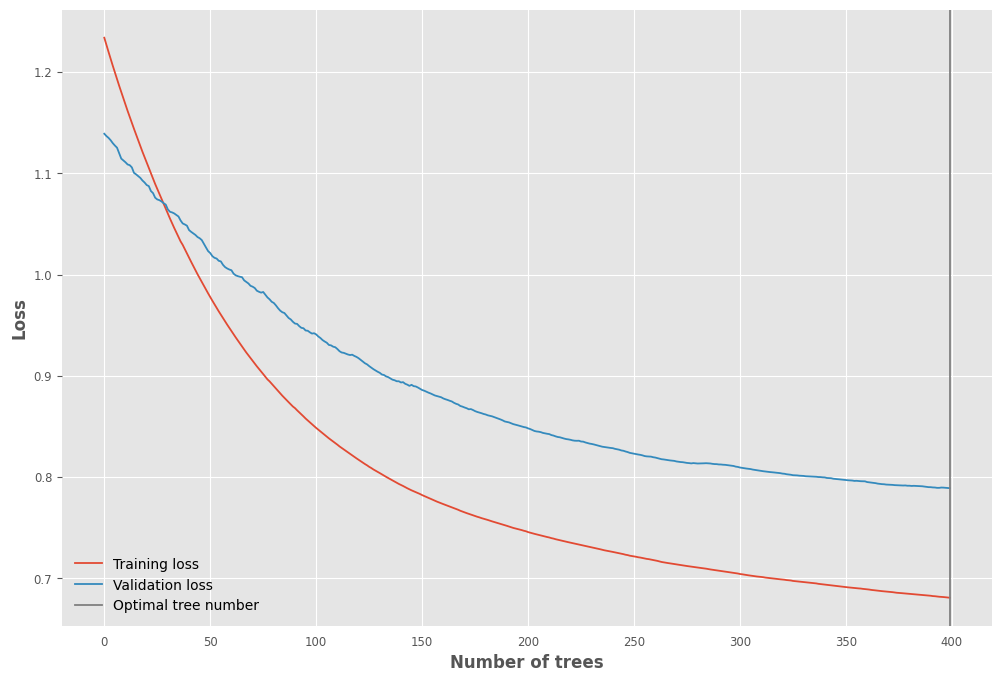

In [68]:
optimal_trees = test_xgb_model.best_iteration
results = test_xgb_model.evals_result()

plt.figure(figsize=(12, 8))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(optimal_trees, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

# Warum Overfitting Diagramm falsch?

<a id="6"></a>
## 5.1 Permutation Importance
https://www.kaggle.com/code/dansbecker/permutation-importance

In [69]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(best_xgb_model).fit(test_X, test_y)
eli5.show_weights(perm, feature_names=test_X.columns.tolist())

Weight,Feature
0.2536 ± 0.0177,car_lag_1
0.0888 ± 0.0137,use_lag_1
0.0424 ± 0.0074,hour
0.0307 ± 0.0054,use_lag_24
0.0305 ± 0.0147,use_lag_2
0.0182 ± 0.0024,venthood_lag_1
0.0098 ± 0.0024,use_lag_168
0.0074 ± 0.0020,outdoor_temp_lag_1
0.0052 ± 0.0019,air_lag_1
0.0051 ± 0.0014,app_outdoor_temp_lag_1


<a id="7"></a>
## 5.2 F-Score

Nein, der F-Score, der aus einer Methode wie .get_fscore() (typischerweise in Bibliotheken wie XGBoost verwendet) und die Feature-Importance, die durch Permutationswichtigkeit (Permutation Importance) ermittelt wird, sind nicht dasselbe. Sie basieren auf unterschiedlichen Methoden zur Bestimmung der Wichtigkeit von Features.

F-Score aus .get_fscore() in XGBoost oder ähnlichen Bibliotheken:

Dieser basiert in der Regel auf der Anzahl der Male, dass ein Feature beim Aufbau der Bäume im Modell verwendet wird.
In Entscheidungsbaum-basierten Modellen wie XGBoost bedeutet ein höherer F-Score, dass das Feature häufiger verwendet wird, um die Bäume zu teilen, was auf eine höhere Wichtigkeit hindeutet.
Dies ist eine intrinsische Methode, die direkt aus dem Trainingsprozess des Modells stammt.
Permutationswichtigkeit (Permutation Importance):

Bei der Permutationswichtigkeit wird die Wichtigkeit eines Features durch das Mischen (Permutieren) der Werte dieses Features über die Beobachtungen hinweg und das Beobachten der Aus
wirkungen auf die Modellleistung ermittelt.

Wenn die Permutation eines Features zu einer erheblichen Verschlechterung der Modellleistung führt, deutet dies darauf hin, dass das Feature wichtig ist.
Diese Methode ist modellagnostisch, was bedeutet, dass sie unabhängig vom verwendeten Modelltyp funktioniert. Sie misst den Einfluss eines Features auf die Vorhersagegenauigkeit des Modells.
Der Hauptunterschied zwischen diesen beiden Methoden liegt in ihrer Herangehensweise:

Der F-Score gibt an, wie oft ein Feature beim Aufbau der Bäume eines Entscheidungsbaummodells verwendet wurde. Es ist eine direktere Messung basierend auf dem Trainingsprozess des Modells.
Die Permutationswichtigkeit misst, wie sich die Vorhersageleistung des Modells ändert, wenn die Werte eines Features zufällig geändert werden. Sie gibt Aufschluss darüber, wie sich die Unordnung eines Features auf die Genauigkeit des Modells auswirkt.
Beide Methoden können nützliche Einblicke in die Wichtigkeit von Features geben, aber sie können unterschiedliche Ergebnisse liefern, je nach den Eigenschaften der Daten und des Modells. In der Praxis ist es oft sinnvoll, beide Methoden zu verwenden, um ein umfassenderes Bild der Feature-Wichtigkeit zu erhalten.

Beispiel: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

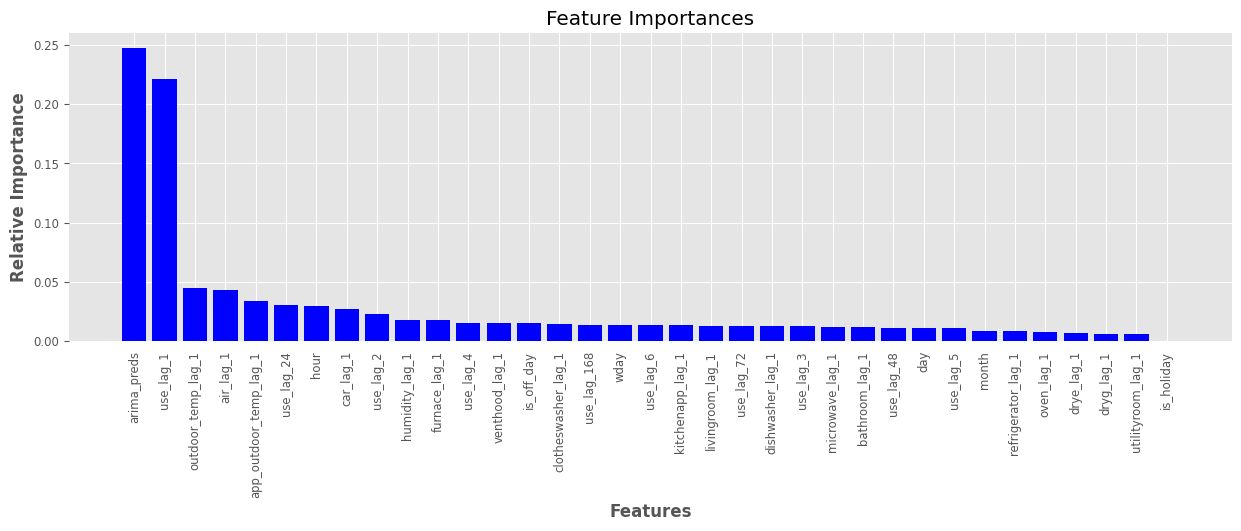

In [70]:
# Feature Labels
feature_labels = train_X.columns

# Extrahieren des RandomForestRegressor aus dem besten Modell
xgb_regressor = best_xgb_model

# Extrahieren der Feature-Importances
feature_importances = xgb_regressor.feature_importances_

# Überprüfen, ob die Anzahl der Features übereinstimmt
if len(feature_labels) != len(feature_importances):
    raise ValueError("Die Anzahl der Features im Modell stimmt nicht mit der Anzahl der ursprünglichen Features überein.")
    
# Zuordnung der Feature-Namen
importance_df = pd.DataFrame({'feature': feature_labels, 'importance': feature_importances})
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Erstellen des Plots
plt.figure(figsize=(15, 4))
plt.title("Feature Importances")
plt.bar(importance_df.feature, importance_df.importance, color='b')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()

<a id="8"></a>
## 5.3 SHAP Values
https://www.kaggle.com/code/dansbecker/shap-values

https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values

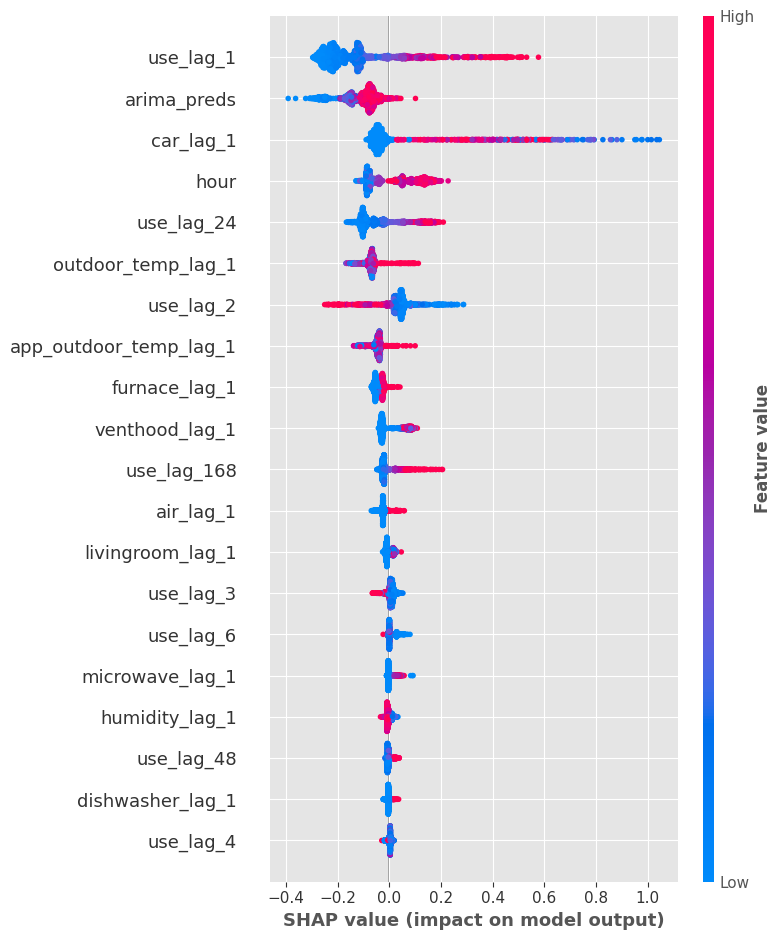

In [71]:
import shap

explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

Interpretation:
* Vertical location shows what feature it is depicting
* Color shows whether that feature was high or low for that row of the dataset
* Horizontal location shows whether the effect of that value caused a higher or lower prediction.

Wenn use_lag_1 einen hohen Wert hat, ist die Vorhersage hoch.

Wenn use_lag_2 einen hohen Wert hat, ist die Vorhersage niedrig.

<a id="9"></a>
## 6. Performance-Vergleich

In [82]:
df_comp = pd.DataFrame(test_y)
df_comp.rename(columns={'use': 'actual'}, inplace=True)
df_comp['arima_preds'] = df.arima_preds
df_comp['lr_preds'] = lr_predictions
df_comp['rf_preds'] = rf_predictions
df_comp['xgb_preds'] = xgb_predictions
df_comp.reset_index(inplace=True)
df_comp.head()

,timestamp,actual,arima_preds,lr_preds,rf_preds,xgb_preds
0,2018-10-20 00:00:00,0.29500,0.548983,0.335852,1.033363,1.042451
1,2018-10-20 01:00:00,0.31450,0.756323,0.303110,0.633309,0.505060
2,2018-10-20 02:00:00,0.26425,0.873021,0.368273,0.625780,0.542196
3,2018-10-20 03:00:00,0.38375,0.938833,0.375075,0.651896,0.564570
4,2018-10-20 04:00:00,0.32200,0.976079,0.336905,0.660975,0.592930


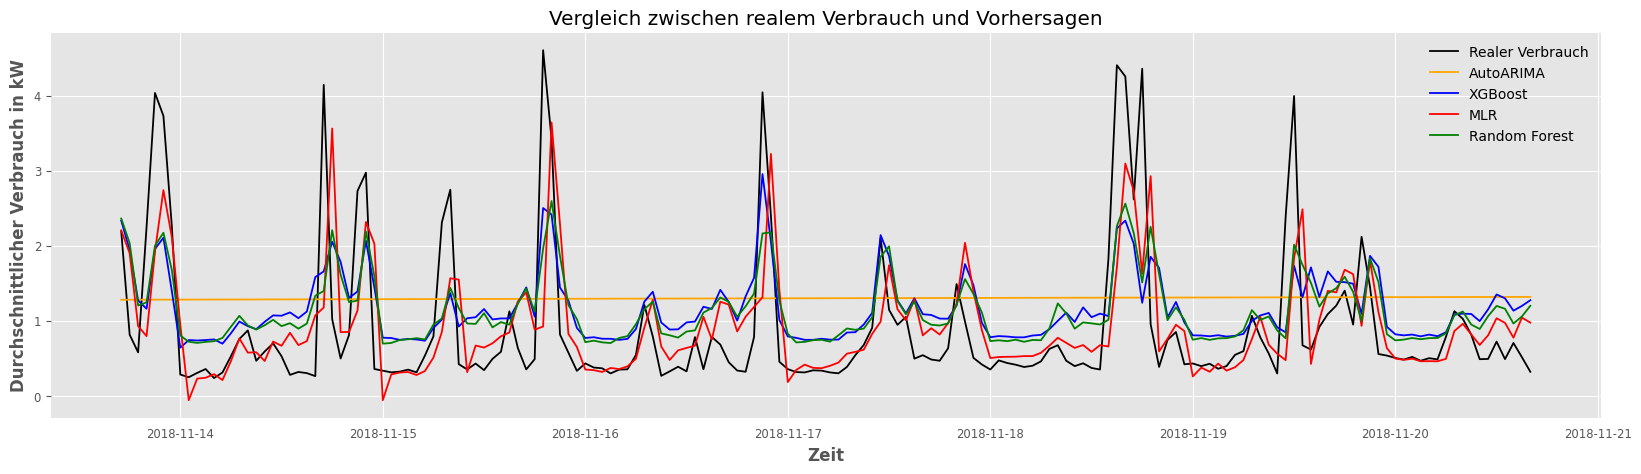

In [83]:
datapoints_per_week = 24 * 7
last_start_idx = len(df_comp) - 1 - datapoints_per_week
start_idx = random.randint(0, last_start_idx)
end_idx = start_idx + datapoints_per_week
df_plot = df_comp[start_idx:end_idx]

plt.figure(figsize=(20, 5))
plt.plot(df_plot.timestamp, df_plot.actual, color='black', label='Realer Verbrauch')
plt.plot(df_plot.timestamp, df_plot.arima_preds, color='orange', label='AutoARIMA')
plt.plot(df_plot.timestamp, df_plot.xgb_preds, color='blue', label='XGBoost')
plt.plot(df_plot.timestamp, df_plot.lr_preds, color='red', label='MLR')
plt.plot(df_plot.timestamp, df_plot.rf_preds, color='green', label='Random Forest')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch in kW')
plt.legend()
plt.show()